## 1. Import Dependencies

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## 2. Read in Image, Grayscale and Blur

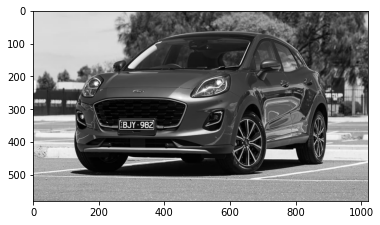

In [16]:
img = cv2.imread('image3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 3. Apply filter and find edges for localization

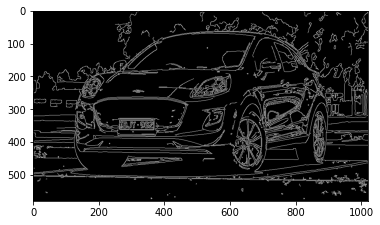

In [17]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection

# The Canny edge detector is an edge detection operator that
# uses a multi-stage algorithm to detect a wide range of edges in images.
# It was developed by John F. Canny in 1986. Canny also produced a computational 
# theory of edge detection explaining why the technique works.
 
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 4. Hard Coded

In [18]:
def edgesMarrHildreth(img, sigma):
	size = int(2*(np.ceil(3*sigma))+1)
	x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
					   np.arange(-size/2+1, size/2+1))

	normal = 1 / (2.0 * np.pi * sigma**2)

	kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * \
		np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal  # LoG filter

	kern_size = kernel.shape[0]
	log = np.zeros_like(img, dtype=float)

	# applying filter
	for i in range(img.shape[0]-(kern_size-1)):
		for j in range(img.shape[1]-(kern_size-1)):
			window = img[i:i+kern_size, j:j+kern_size] * kernel
			log[i, j] = np.sum(window)

	log = log.astype(np.int64, copy=False)

	zero_crossing = np.zeros_like(log)

	# computing zero crossing
	for i in range(log.shape[0]-(kern_size-1)):
		for j in range(log.shape[1]-(kern_size-1)):
			if log[i][j] == 0:
				if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] < 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
					zero_crossing[i][j] = 255
			if log[i][j] < 0:
				if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
					zero_crossing[i][j] = 255
	return sigma*2, zero_crossing

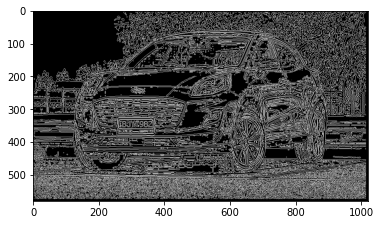

In [19]:
fg_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray2 = cv2.cvtColor(fg_rgb, cv2.COLOR_RGB2GRAY)
edged2 = edgesMarrHildreth(gray2, 1)
# plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.imshow(edged2[1], cmap='gray')
log = edged2[1].astype(np.uint8)

## 5. Find Contours and Apply Mask

In [20]:
keypoints = cv2.findContours(log.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [21]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    # print(approx)
    if len(approx) == 4:
        location = approx
        break

In [22]:
location

In [23]:
if location == None:
	print("nothing found :( ")
	exit()
else:
	mask = np.zeros(gray.shape, np.uint8)
	new_image = cv2.drawContours(mask, [location], 0,255, -1)
	new_image = cv2.bitwise_and(img, img, mask=mask)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2599: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'


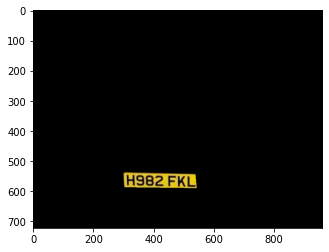

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

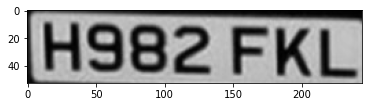

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 6. Use Easy OCR To Read Text

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[2, 0], [244, 0], [244, 53], [2, 53]], 'H98z FKL', 0.46375083196430983)]

## 6. Render Result

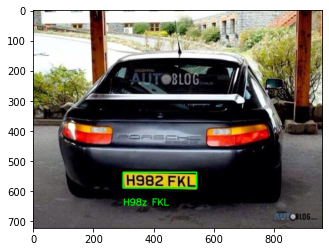

In [ ]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))